In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

Preparing the dataset

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize

In [3]:
def resize_all(src, pklname, include, width=150, height=None):
  height = height if height is not None else width
     
  data = dict()
  data['description'] = 'resized ({0}x{1}) heatmap images in rgb'.format(int(width), int(height))
  data['label'] = []
  data['filename'] = []
  data['data'] = []   
      
  pklname = f"{pklname}_{width}x{height}px.pkl"
  
  # read all images in PATH, resize and write to DESTINATION_PATH
  for subdir in os.listdir(src):
    if subdir in include:
      print(subdir)
      current_path = os.path.join(src, subdir)

      for file in os.listdir(current_path):
        if file[-3:] in {'jpg', 'png'}:
          im = imread(os.path.join(current_path, file))
          im = resize(im, (width, height)) #[:,:,::-1]
          data['label'].append(subdir)
          data['filename'].append(file)
          data['data'].append(im)

        joblib.dump(data, pklname)

In [4]:
data_path = r"C:\Users\srima\Downloads\DRONE_DATA-20210505T032944Z-001\DRONE_DATA"
os.listdir(data_path)

['.ipynb_checkpoints',
 'HEAT_MAPS_480x480px.pkl',
 'newplot - 2021-04-28T192615.464.png',
 'Notebook_I_Running_CNN_on_HeatMaps.ipynb',
 'Parrot_Mambo_Fly_SVM',
 'Parrot_Swing_SVM',
 'Tello_SVM',
 'Untitled0.ipynb',
 'untitled0.py']

In [5]:
base_name = 'HEAT_MAPS'
width = 480

include = {'Tello', 'Parrot_Swing', 'Parrot_Mambo_Fly'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

It took approximately 5 minutes to resize 100 heatmaps in each folder. In other words, it took 5 minutes for the above cell to be run completely.

In [6]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

print('Number of samples: ', len(data['data']))
print('Keys: ', list(data.keys()))
print('Description: ', data['description'])
print('Image Shape: ', data['data'][0].shape)
print('Labels:', np.unique(data['label']))
 
Counter(data['label'])

Number of samples:  300
Keys:  ['description', 'label', 'filename', 'data']
Description:  resized (480x480) heatmap images in rgb
Image Shape:  (480, 480, 4)
Labels: ['Parrot_Mambo' 'Parrot_S' 'T']


Counter({'Parrot_Mambo': 100, 'Parrot_S': 100, 'T': 100})

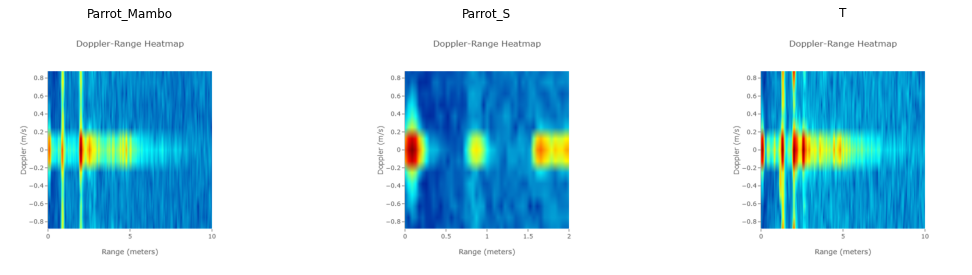

In [7]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [8]:
X = np.array(data['data'])
y = np.array(data['label'])

In [9]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

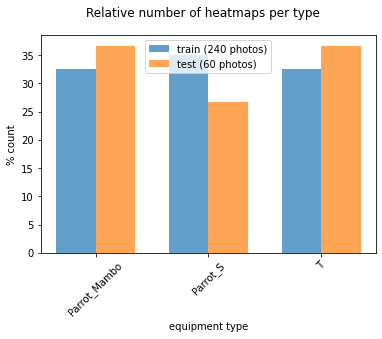

In [10]:
def plot_bar(y, loc = 'left', relative = True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts = True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align = 'center', alpha = .7, width = width)
    plt.xticks(xtemp, unique, rotation = 45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('Relative number of heatmaps per type')
plot_bar(y_train, loc = 'left')
plot_bar(y_test, loc = 'right')
plt.legend(['train ({0} photos)'.format(len(y_train)),'test ({0} photos)'.format(len(y_test))])

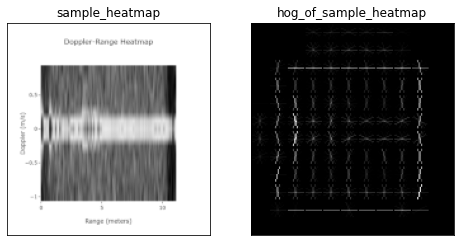

In [11]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
sample_heatmap = imread(r'C:\Users\srima\Downloads\DRONE_DATA-20210505T032944Z-001\DRONE_DATA\newplot - 2021-04-28T192615.464.png',
       as_gray = True)


# scale down the image to one third
sample_heatmap = rescale(sample_heatmap, 1/3, mode = 'reflect')
# calculate the hog and return a visual representation.
sample_heatmap_hog, sample_heatmap_hog_img = hog(sample_heatmap, pixels_per_cell = (14,14),
                                                 cells_per_block = (2, 2),
                                                 orientations = 9,
                                                 visualize = True,
                                                 block_norm = 'L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False) for a in ax]
 
ax[0].imshow(sample_heatmap, cmap = 'gray')
ax[0].set_title('sample_heatmap')
ax[1].imshow(sample_heatmap_hog_img, cmap = 'gray')
ax[1].set_title('hog_of_sample_heatmap')
plt.show()

The above sample heatmap does not belong to any of the classes. The above heatmap was used to demonstrate the operation of HOG.

In [12]:
print('Number of Pixels: ', sample_heatmap.shape[0] * sample_heatmap.shape[1])
print('Number of HOG Features: ', sample_heatmap_hog_img.shape[0])

Number of Pixels:  26720
Number of HOG Features:  167


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
    def __init__(self):
        pass
 
    def fit(self, X, y = None):
        """returns itself"""
        return self

    def transform(self, X, y = None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])

In [14]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y = None, orientations = 9,
                 pixels_per_cell = (8, 8),
                 cells_per_block = (3, 3), block_norm = 'L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
 
        def local_hog(X):
            return hog(X,
                       orientations = self.orientations,
                       pixels_per_cell = self.pixels_per_cell,
                       cells_per_block = self.cells_per_block,
                       block_norm = self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(pixels_per_cell = (14, 14),
                        cells_per_block = (2,2),
                        orientations = 9,
                        block_norm = 'L2-Hys'
                       )
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train_prepared.shape)

<ipython-input-13-7b06da50e508>:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  return np.array([skimage.color.rgb2gray(img) for img in X])


(240, 39204)


In [16]:
sgd_clf = SGDClassifier(random_state = 42, max_iter = 1000, tol = 1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [17]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

<ipython-input-13-7b06da50e508>:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  return np.array([skimage.color.rgb2gray(img) for img in X])


In [18]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  95.0


In [19]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test, y_pred)
cmx

array([[20,  0,  2],
       [ 0, 16,  0],
       [ 1,  0, 21]], dtype=int64)


 ['Parrot_Mambo', 'Parrot_S', 'T']


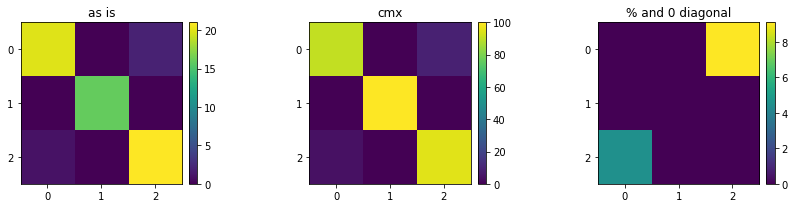

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('cmx')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [21]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


<ipython-input-13-7b06da50e508>:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  return np.array([skimage.color.rgb2gray(img) for img in X])
<ipython-input-13-7b06da50e508>:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  return np.array([skimage.color.rgb2gray(img) for img in X])


Percentage correct:  95.0
